In [1]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import sklearn related libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Importing decomposition libraries.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import encoders.
import category_encoders as ce

# Import clustering algorithms.
from sklearn.cluster import KMeans

# Import scaling libraries.
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# Import sampling techniques.
from imblearn.over_sampling import SMOTE

# Import sampling libraries.
from sklearn.utils import resample

In [106]:
# Load the data.
data_orig = pd.read_csv('data/musk_csv.csv')
data = pd.read_csv('data/musk_csv.csv')

In [107]:
# Function to identify null values in every column.
def find_null(data):
    """ This function will print the null values in the data column-wise."""
    col_list = data.columns
    for c in col_list:
        temp_count = len(data[data[c].isnull()])
        print( ' Null values in column ', c , ' are ', temp_count)
  

In [108]:
find_null(data)

 Null values in column  ID  are  0
 Null values in column  molecule_name  are  0
 Null values in column  conformation_name  are  0
 Null values in column  f1  are  0
 Null values in column  f2  are  0
 Null values in column  f3  are  0
 Null values in column  f4  are  0
 Null values in column  f5  are  0
 Null values in column  f6  are  0
 Null values in column  f7  are  0
 Null values in column  f8  are  0
 Null values in column  f9  are  0
 Null values in column  f10  are  0
 Null values in column  f11  are  0
 Null values in column  f12  are  0
 Null values in column  f13  are  0
 Null values in column  f14  are  0
 Null values in column  f15  are  0
 Null values in column  f16  are  0
 Null values in column  f17  are  0
 Null values in column  f18  are  0
 Null values in column  f19  are  0
 Null values in column  f20  are  0
 Null values in column  f21  are  0
 Null values in column  f22  are  0
 Null values in column  f23  are  0
 Null values in column  f24  are  0
 Null values i

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 170 entries, ID to class
dtypes: int64(168), object(2)
memory usage: 8.6+ MB


## Our data has no null values.

# Exploratory data analysis.

### Helper Functions

In [6]:
def groupby_column(df , col_name):
    """
    Returns Frequency of each type given in column name.
    Input:
    df: DataFrame
    col_name: name of column.
    Output:
    Frequncy dataframe.
    """
    temp_group = df.groupby(col_name).count()
    temp_index = temp_group.index
    temp_dict = {col_name:0 , 'Frequency':0}
    counter = 0
    
    for i in temp_index:
        if counter == 0:
            # Initialize the data Frame
            temp_freq = temp_group.loc[i][0]
            temp_dict[col_name] = i
            temp_dict['Frequency'] = temp_freq
            
            # Append the dataframe.
            temp_df = pd.DataFrame([temp_dict])
            counter += 1
        else:    
            # Initialize the data Frame
            temp_freq = temp_group.loc[i][0]
            temp_dict[col_name] = i
            temp_dict['Frequency'] = temp_freq

            # Append the dataframe.
            temp_df = temp_df.append([temp_dict] , ignore_index = True)
    return temp_df.sort_values(by = 'Frequency' , ascending=False)

def plot_frequency(df ,  top_x , col_name = 'Frequency' ):
    """
    Function to plot the frequency dataframe.
    Input: 
    df: Frequency dataframe.
    col_name: Name of column containing the frequency.
    top_x = X top features sorted by frequency.
    Output:
    Bar graph.
    """
    df = df[:top_x]
    plt.figure(figsize=(15,15))
    sns.barplot(data = df , y = df.columns[0] , x = col_name )
    plt.title('Frequency Distribution.')
    
    
    # Define a function to extract multilevel groups.
def count_multilevel_groups(dataframe , col_name,def_col = 'class'):
    """
    Function to group on Class and the column name given and return the frequency data-frame.
    """
    # Group the dataframe by Sales and col name.
    temp_group = dataframe.groupby([def_col,col_name]).count()['f1']
    
    # Extract the false sales and true sales and sort them in descending order and store in dictionary.
    temp_false = temp_group.loc[0].sort_values(ascending = False)
    false_dict = {'index':temp_false.index , 'Frequency': temp_false.values}
    temp_true = temp_group.loc[1].sort_values(ascending = False)
    true_dict = {'index':temp_true.index , 'Frequency': temp_true[:].values}
    
    # Group the data frame.
    temp_df_t = pd.DataFrame(true_dict)
    temp_df_t['Class'] = 1
    temp_df_f = pd.DataFrame(false_dict)
    temp_df_f['Class'] = 0
    temp_df = pd.concat([temp_df_t , temp_df_f])
    temp_df.rename(columns = {'index':col_name} , inplace = True)
    
    # Return the dataframe
    return temp_df

def get_variance_ratio(df , n_features):
    """
    Function to find out the explained variance ration based on the number of components given.
    Input: 
    df: DataFrame
    n_features: Number of features.
    Output:
    Dataframe containing the pca's and explained variance_ratios.
    """
    # Initialize PCA.
    pca = PCA(n_components=n_features)
    pca.fit_transform(df)
    
    # Find the variance ratios.
    values = pca.explained_variance_ratio_
    names = ["PC" + str(x) for x in range(len(values))]
    #Initialize and append the dataframe.
    col = ['PC' , 'Information_Ratio']
    temp_df = pd.DataFrame(columns=col)
    temp_df['PC'] = names
    temp_df['Information_Ratio'] = values
    
    return temp_df

def find_cumulative_ratio(df , ratio , col_name = 'Information_Ratio'):
    """
    Function to calculate how many features can capture the desired ratio of information.
    Input:
    df: Information Ratio Dataframe.
    ratio: Desired ratio.
    col_name: Column name containing the information ratio.
    Output:
    Number of features which can capture the desired percentage of information.
    
    """
    
    sum = 0
    counter = 0
    for s in df[col_name]:
        sum+= s
        counter+=1
        
        if (sum>=ratio):
            print('Information_Captured is ', sum , 'by ' , counter , ' features' )
            return counter 
        
def create_pca_df(df , pca_df , n_components = 8):
    """
    This function will return a pca df with the desired number of components.
    Input:
    df = DataFrame containing variables on which PCA won't be applied.
    pca_df: DataFrame containing features to transform using PCA.
    n_components = number of features to use in dataframe.
    Output:
    PCA dataframe.
    
    """
    
    # Create the model.
    pca = PCA(n_components=n_components)
    
    # Transform the values.
    pca_values = pca.fit_transform(pca_df)
    
    # Create the pca dataframe.
    pca_df_transformed = pd.DataFrame(data = pca_values , columns=["PC" + str(x) for x in range(n_components) ])
    
    # Concatenate with original dataframe.
    temp_df = pd.concat([df , pca_df_transformed] ,axis=1 , join='inner')
    
    # Return the PCA dataframe.
    return temp_df        

# Define an algorithm to find all the metrics of score and plot the roc curve
def plot_performance(model , x_tr , x_ts , y_tr , y_ts , plt_title = 'Performnce Mertics'):
    model.fit(x_tr, y_tr)
    ns_prob = [0 for i in range(len(y_ts))]
    lg_prob = model.predict_proba(x_ts)
    y_pred = model.predict(x_ts)
    lg_prob = lg_prob[:,1]
    ns_auc = roc_auc_score(y_ts, ns_prob)
    lr_auc = roc_auc_score(y_ts, lg_prob)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Accuracy:' , accuracy_score(y_ts, y_pred))
    print('Precision:' , precision_score(y_ts, y_pred))
    print('Recall:' , recall_score(y_ts, y_pred))
    print('F1 Score: ', f1_score(y_ts , y_pred))
    # plot the roc curve for the model
    ns_fpr, ns_tpr, _ = roc_curve(y_ts, ns_prob)
    lr_fpr, lr_tpr, _ = roc_curve(y_ts, lg_prob)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.title(plt_title)
    plt.show()
    
def calc_kfold_scores(x , y ,  model, splits = 10):
    """
    Calculates accuracy , precision and recall scores using KFold validation using the data-set provided in the question.
    Input: 
    x: The independent variables.
    y: Target Variable.
    model: Model to be used for classification.
    split: n_split in kfold.
    Output:
    Dictionary containing the accuracy , precision, recall for each split.
    
    """
    acc = []
    rec = []
    pre = []
    kf = KFold(n_splits=splits)
    
    for tr , ts in kf.split(x , y ):
        x_tr = x.loc[tr]
        x_ts = x.loc[ts]
        y_tr = y.loc[tr]
        y_ts = y.loc[ts]
        model.fit(x_tr , y_tr)
        y_pred = model.predict(x_ts)
        acc.append(accuracy_score(y_ts , y_pred))
        rec.append(recall_score(y_ts , y_pred))
        pre.append(precision_score(y_ts , y_pred))
        
    print('KFold scores with splits = ' , splits)
    print('Accuracy score ' , np.mean(acc))
    print('Recall score ' , np.mean(rec))
    print('Precision score ' , np.mean(pre))
    return {'accuracy':acc , 'precision': pre , 'recall':rec}    

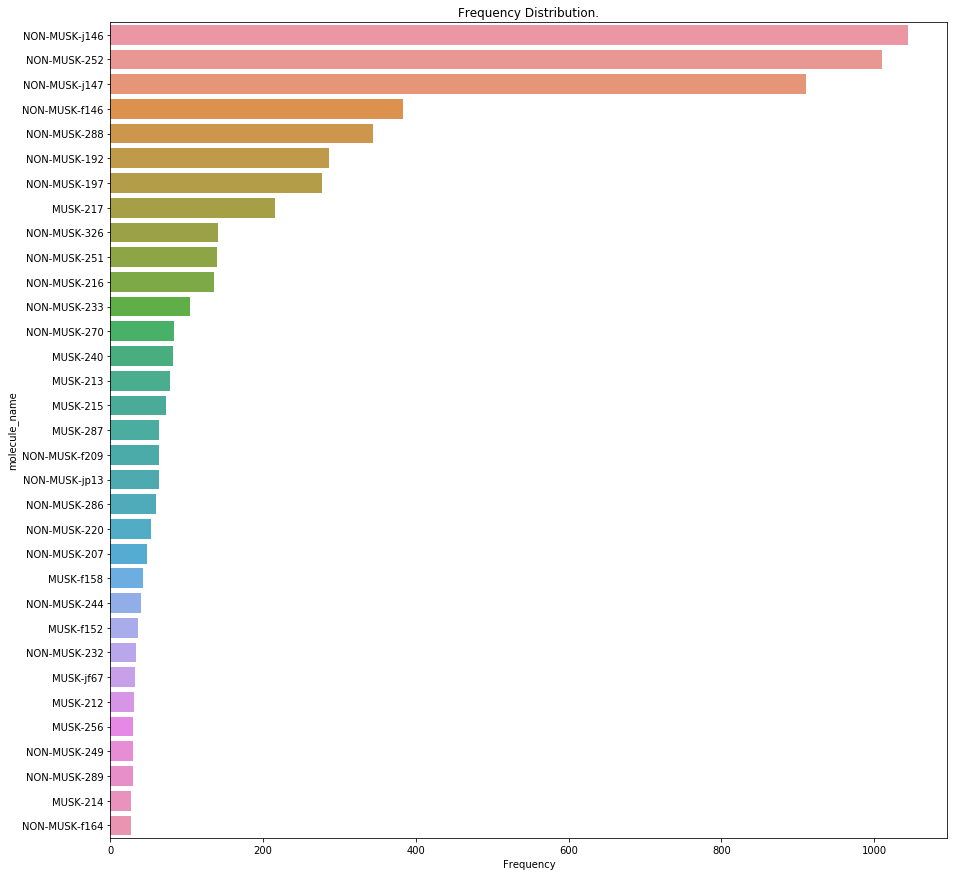

In [7]:
# Analysing the column molecule name.
df = groupby_column(data , 'molecule_name')
plot_frequency(df , 33)

In [8]:
print('Frequency of top 33 molecules: ' ,df[:33]['Frequency'].sum())

Frequency of top 33 molecules:  6013


### Top ten molecules as per frequency occur in 91% of the data. 

## Analysing frequency of conformation name.

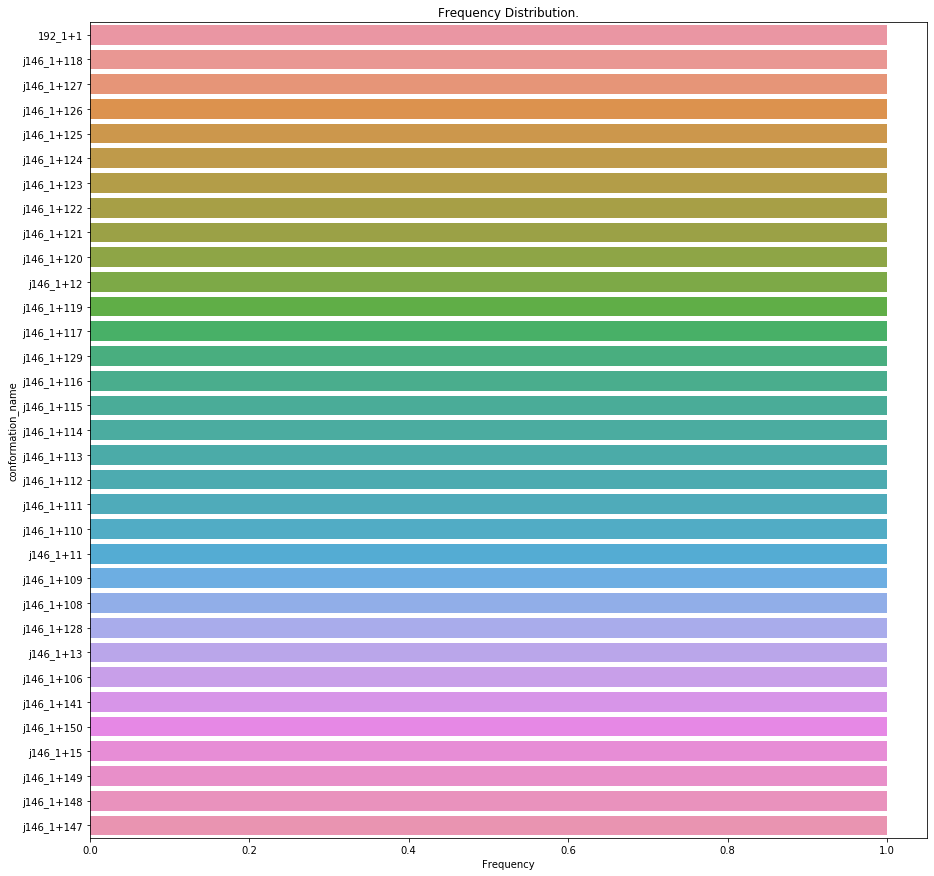

In [9]:
df = groupby_column(data , 'conformation_name')
plot_frequency(df , 33)

In [10]:
df['Frequency'].unique()

array([1], dtype=int64)

### Every conformation name maps to one unique compound. Hence this column won't help me classify the chemical compounds as this can be interpreted as a unique id for each chemical compund.

## Analysing frequency of target class.

([<matplotlib.patches.Wedge at 0x20f219b8f88>,
 [Text(-0.973533148497799, 0.5120871105348802, 'Non-Musk'),
  Text(0.9735331484977989, -0.5120871105348803, 'Musk')],
 [Text(-0.5310180809987994, 0.2793202421099346, '84.6%'),
  Text(0.5310180809987993, -0.27932024210993467, '15.4%')])

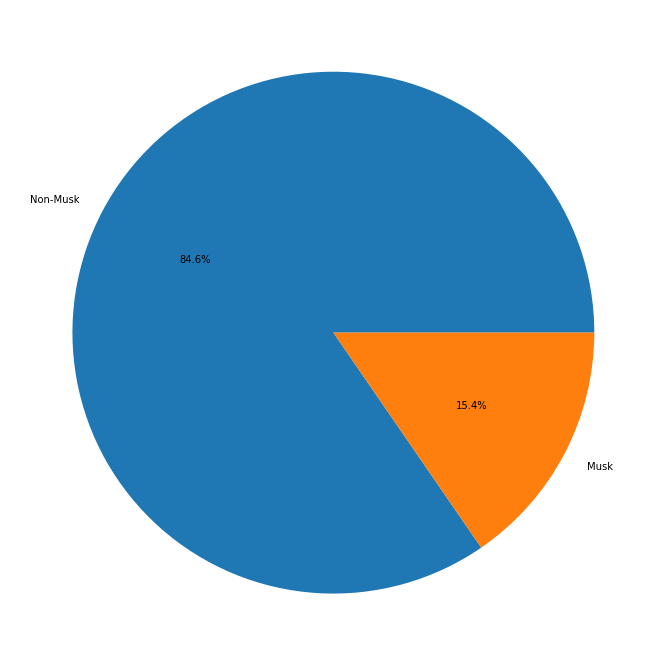

In [11]:
df = groupby_column(data , 'class')
plt.figure(figsize=(12,12))
plt.pie( x = df.Frequency , labels=['Non-Musk' , 'Musk'] , autopct='%.1f%%')

### As you can see the dataset is imbalanced. The frequency of majority class i.e Number of Non Musk  compunds are a lot greater than the frequency of Musk Chemical Compounds.

## Analysing the frequency of Musk chemical with respect to their molecule name.

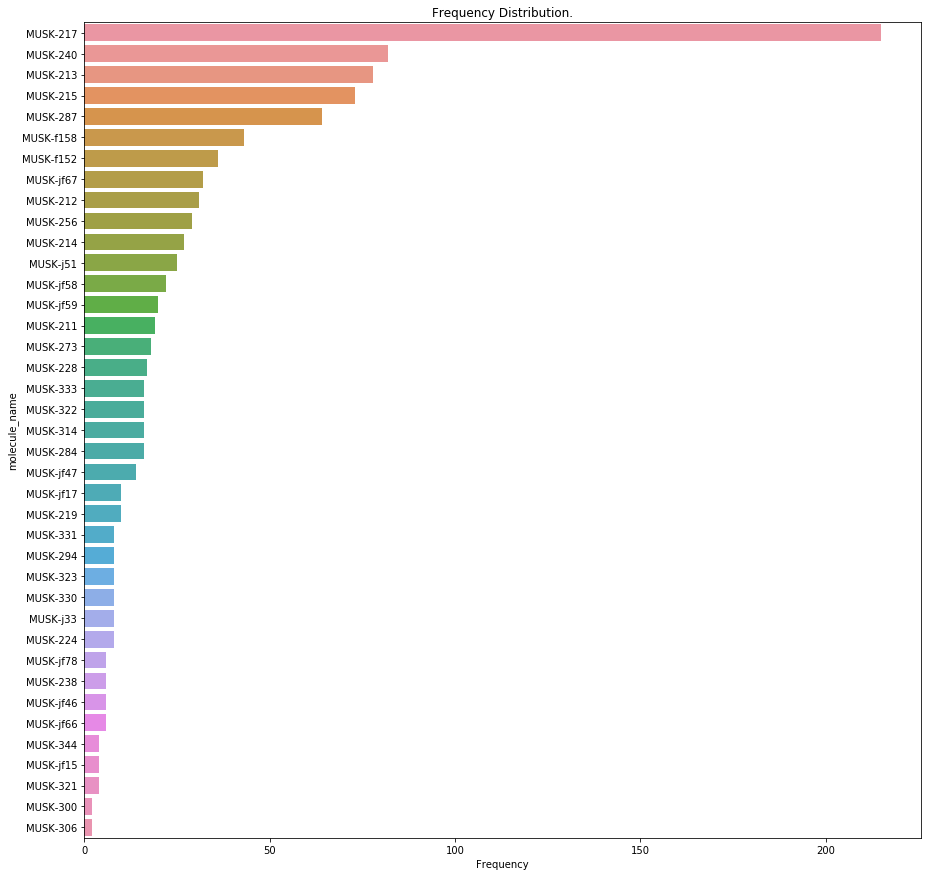

In [12]:
df = count_multilevel_groups(data , 'molecule_name')
df = df[df['Class']==1]
plot_frequency(df,len(df))

### As we can see Musk-217 is the most commonly occuring musk compound. This just shows that molecule_name is going to be an important feature in our classification problem. Also , we can note that every musk compound has MUSK in the molecule name.

## Analysing the frequency of Non-Musk Chemical Compounds with respect to their molecule name.

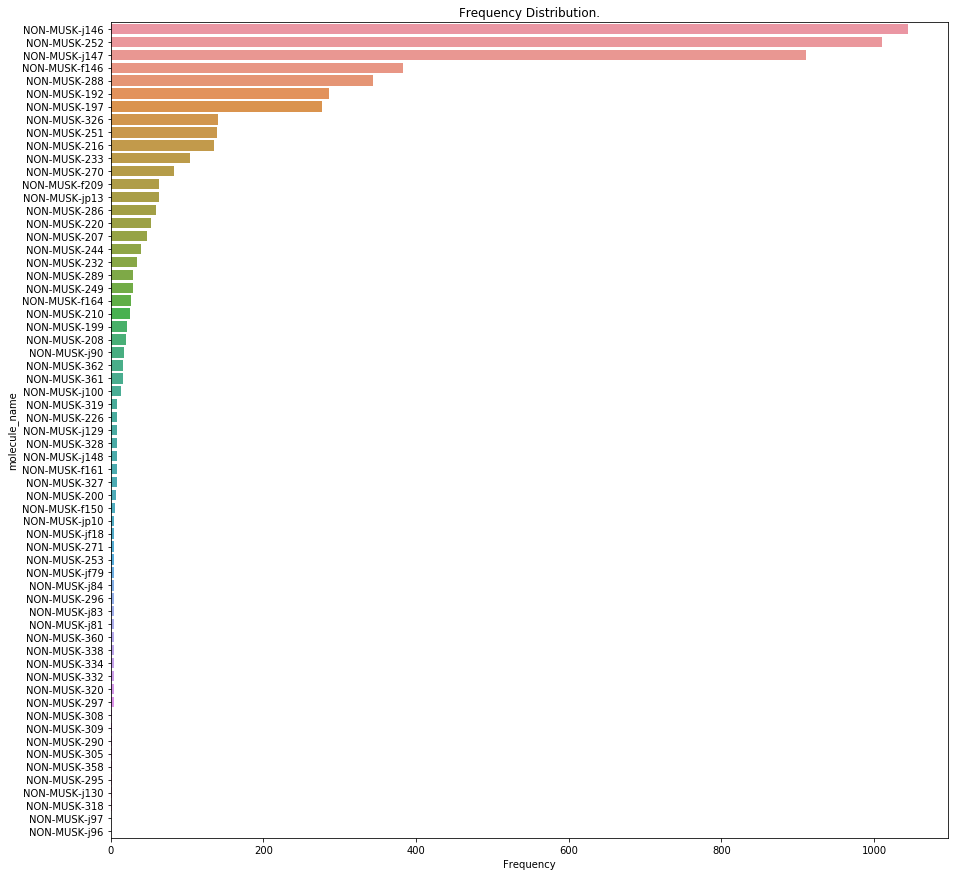

In [13]:
df = count_multilevel_groups(data , 'molecule_name')
df = df[df['Class']==0]
plot_frequency(df,len(df))

### We can note that every non-musk compound has NON-MUSK in the molecule name.

# Data Encoding

### The problems that we will face in classifying the compound:
### 1. Imbalanced Data-Set
### 2. High Dimensionality of the data.

In [14]:
# Drop the columns ID and conformation_name as they won't contribute to our model.
data.drop(columns=['ID','conformation_name'] , axis = 1 , inplace=True)

# Encode the column molecule_name using binary encoder as unique columns names are just 102.
encoder = ce.BinaryEncoder(cols=['molecule_name'])
data = encoder.fit_transform(data)
data_for_scaling = data.copy()

# Scaling the columns f1 to f166 using robust scaler.
data_for_scaling.drop(columns = data.columns[:8] , axis = 1 , inplace=True)
data_for_scaling.drop(columns = ['class'] , axis = 1 , inplace = True)
robust_scaler = RobustScaler()
scaled_data = pd.DataFrame(robust_scaler.fit_transform(data_for_scaling))

# Drop the original f1 to f166 columns and replace them with scaled data.
data.drop(columns=data_for_scaling.columns , axis = 1 , inplace = True)
data[data_for_scaling.columns] = pd.DataFrame(scaled_data)

## Gaining intuition about columns f1-f166 by randomly plotting them using scatter plot

In [15]:
# Segregate the df based on class.
data_1 = data[data['class'] == 1]
data_0 = data[data['class'] == 0]

<Figure size 864x864 with 0 Axes>

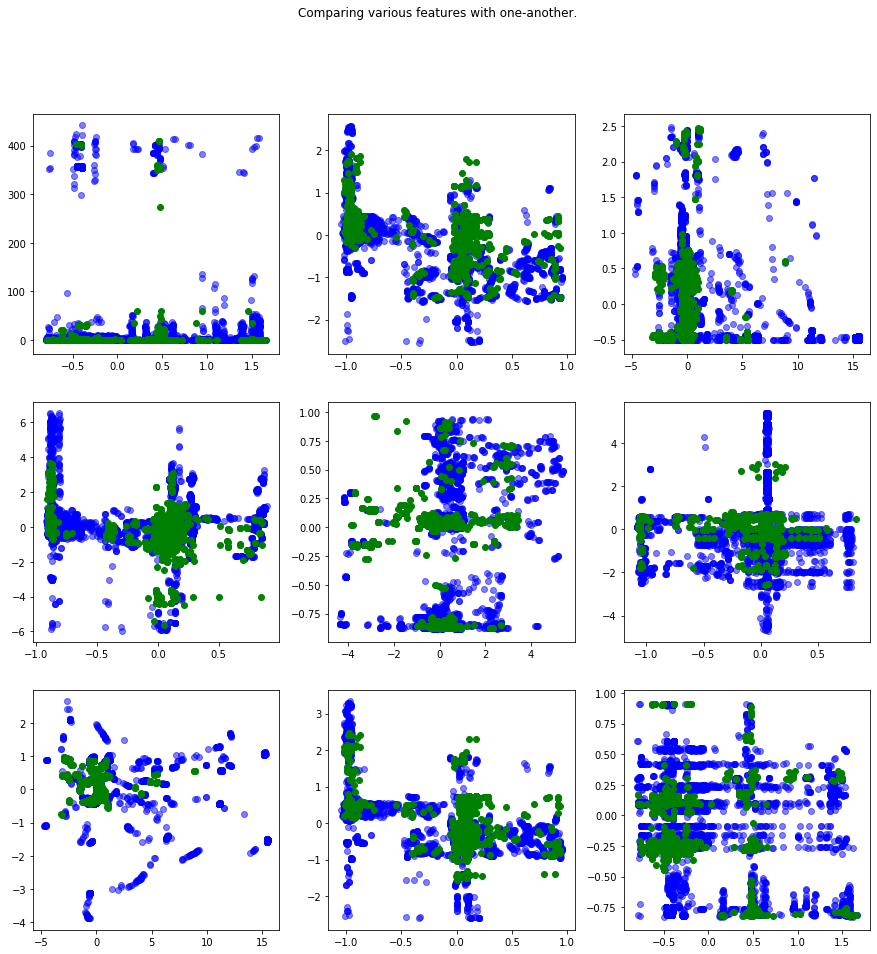

In [16]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots(3, 3)
fig.suptitle('Comparing various features with one-another.')
fig.set_figheight(15)
fig.set_figwidth(15)
ax[0, 0].scatter(x = data_0['f4'] , y = data_0['f5'] , color = 'blue' , alpha=0.5)
ax[0,0].scatter(x = data_1['f4'] , y = data_1['f5'] , color = 'green')
ax[0, 1].scatter(x = data_0['f9'] , y = data_0['f10'] , color = 'blue' , alpha=0.5)
ax[0,1].scatter(x = data_1['f9'] , y = data_1['f10'] , color = 'green')
ax[0, 2].scatter(x = data_0['f1'] , y = data_0['f2'] , color = 'blue' , alpha=0.5)
ax[0,2].scatter(x = data_1['f1'] , y = data_1['f2'] , color = 'green')
ax[1, 0].scatter(x = data_0['f7'] , y = data_0['f13'] , color = 'blue' , alpha=0.5)
ax[1,0].scatter(x = data_1['f7'] , y = data_1['f13'] , color = 'green')
ax[1, 1].scatter(x = data_0['f20'] , y = data_0['f25'] , color = 'blue' , alpha=0.5)
ax[1,1].scatter(x = data_1['f20'] , y = data_1['f25'] , color = 'green')
ax[1, 2].scatter(x = data_0['f100'] , y = data_0['f165'] , color = 'blue' , alpha=0.5)
ax[1,2].scatter(x = data_1['f100'] , y = data_1['f165'] , color = 'green')
ax[2, 0].scatter(x = data_0['f1'] , y = data_0['f166'] , color = 'blue' , alpha=0.5)
ax[2,0].scatter(x = data_1['f1'] , y = data_1['f166'] , color = 'green')
ax[2, 1].scatter(x = data_0['f9'] , y = data_0['f50'] , color = 'blue' , alpha=0.5)
ax[2,1].scatter(x = data_1['f9'] , y = data_1['f50'] , color = 'green')
ax[2, 2].scatter(x = data_0['f4'] , y = data_0['f156'] , color = 'blue' , alpha=0.5)
ax[2,2].scatter(x = data_1['f4'] , y = data_1['f156'] , color = 'green')
plt.show()

### As we can see from plot[0,1], plot[2,0] , plot[2,1] , plot[2,2] , plot[3,1] nad plot[3,2] some features are highly correlated to each other.

## PCA Dimensionality Reduction.

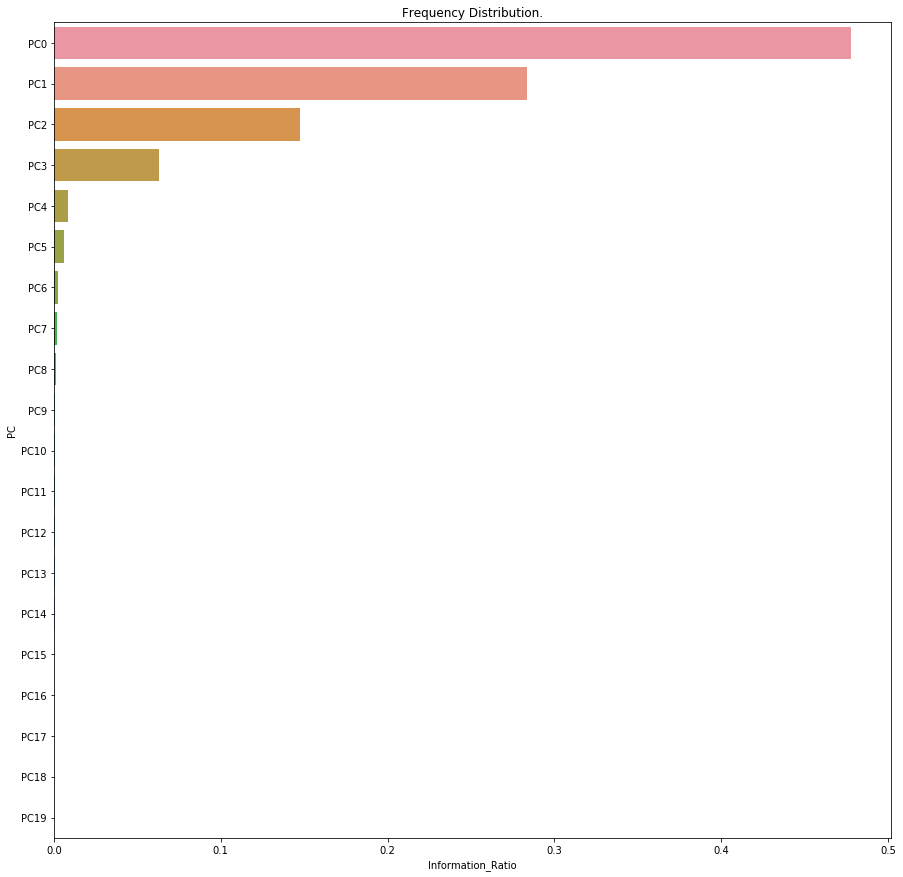

In [17]:
# Reducing the dimensionality using PCA.
pca_ratios = get_variance_ratio(scaled_data , n_features= len(pd.DataFrame(scaled_data).columns))
plot_frequency(pca_ratios , 20 , col_name='Information_Ratio')

In [18]:
# Find the number of features required to capture 99% of the information.
n_features = find_cumulative_ratio(pca_ratios , ratio=.99)    

Information_Captured is  0.9907064146430369 by  8  features


### As we can see 99% of information is captured by our data using the top 8 features. So PCA will be a good choice for dimensionality reduction.

In [19]:
# Creating our PCA dataset.

# Create seperate dataframe for features that won't be transformed using PCA.
data_without_f166 = data[['molecule_name_0', 'molecule_name_1', 'molecule_name_2',
       'molecule_name_3', 'molecule_name_4', 'molecule_name_5',
       'molecule_name_6', 'molecule_name_7', 'class']]

# Generate our dataset.
data_pca = create_pca_df(data_without_f166 , scaled_data ,n_components=8)

In [20]:
data_pca

,molecule_name_0,molecule_name_1,molecule_name_2,molecule_name_3,molecule_name_4,molecule_name_5,molecule_name_6,molecule_name_7,class,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0,0,0,0,0,0,0,1,1,-15.207430,-13.459252,-2.876378,-6.746073,-4.499892,-0.796751,5.370598,0.989699
1,0,0,0,0,0,0,0,1,1,-15.167740,-13.492969,-2.871039,-7.296466,-4.344457,-1.131875,3.708676,-3.573753
2,0,0,0,0,0,0,0,1,1,-15.174375,-13.500020,-2.894699,-7.265601,-4.494439,-1.192548,3.790495,-2.669667
3,0,0,0,0,0,0,0,1,1,-15.180688,-13.455793,-2.890442,-6.801907,-4.445403,-1.199986,3.755817,-3.537337
4,0,0,0,0,0,0,0,1,1,-15.180676,-13.455811,-2.890508,-6.802073,-4.445271,-1.200038,3.759069,-3.536286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,0,1,1,0,0,1,1,0,0,-15.033738,-15.067980,-0.823183,-7.885825,30.119925,-1.411659,2.461867,-2.037494
6594,0,1,1,0,0,1,1,0,0,-14.989590,-15.218236,-0.851570,-8.098780,30.128804,-2.904925,2.164128,-2.195626
6595,0,1,1,0,0,1,1,0,0,-14.652202,-14.723761,-1.840536,-7.234588,-0.724149,-2.079642,1.451574,5.151771
6596,0,1,1,0,0,1,1,0,0,-15.170280,-14.608144,-2.754207,-7.500345,-2.167522,-0.398144,1.439225,5.546702


## Creating model

## 1. Logistic Regression

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score:  1.0


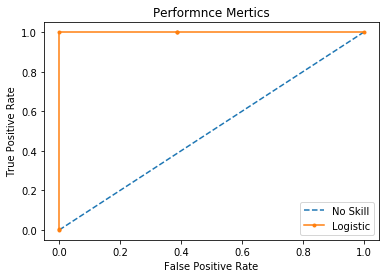

In [21]:
# Define X and Y.
x = data_pca.drop(columns=['class'] , axis=1 )
y = data_pca['class']

# Finding the performance of unscaled model
model = LogisticRegression(solver='lbfgs' , max_iter=1000)
x_tr , x_ts , y_tr, y_ts = train_test_split(x,y,test_size = 0.20 , random_state = 42)
plot_performance(model , x_tr , x_ts , y_tr, y_ts)


### As you can see, we are getting a perfect score. This is because of the molecule-name column as it can perfect identify the MUSK and NON-MUSK compounds. However , for my further models we wont use the columns molecule_name as in real-scenario we might not get compounds classified so well on molecule name.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.742
Accuracy: 0.8416666666666667
Precision: 0.0
Recall: 0.0
F1 Score:  0.0


D:\Programming\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programming\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


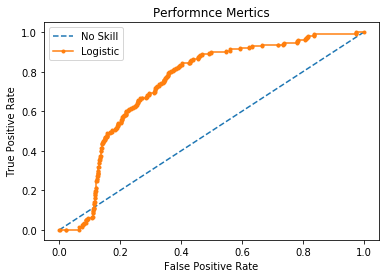

In [22]:
x = data_pca.drop(columns = ['molecule_name_0', 'molecule_name_1', 'molecule_name_2',
       'molecule_name_3', 'molecule_name_4', 'molecule_name_5',
       'molecule_name_6', 'molecule_name_7','class'] , axis = 1)
y = data_pca['class']

# Finding the performance of unscaled model without column molecule name.
model = LogisticRegression(solver='lbfgs' , max_iter=1000)
x_tr , x_ts , y_tr, y_ts = train_test_split(x,y,test_size = 0.20 , random_state = 42)
plot_performance(model , x_tr , x_ts , y_tr, y_ts)


### The AUCROC is the 73.2% which is indicative that the there is some seperability between the classes. The precision and recall are 0% showing that our model is performing very poorly as it is identifying everything as non-musk compound.

## Oversampling 

### We won't be using under-sampling because we lose a lot of information about the majority class. We will be using SMOTE oversampling. SMOTE over-sampling increases the count of minority class by creating synthetic data point close to the real data.

In [23]:
# Split x, y into train and test.
x_tr , x_ts , y_tr, y_ts = train_test_split(x,y,test_size = 0.20 , random_state = 42)

# Over-Sample the train data.
x_tr , y_tr = SMOTE().fit_resample(x_tr , y_tr )

In [24]:
# Show the value counts of train data-set.
pd.Series(y_tr).value_counts()

1    4470
0    4470
dtype: int64

In [25]:
# Show the value-count of test-data set.
y_ts.value_counts()

0    1111
1     209
Name: class, dtype: int64

## Logistic Regression Classification model.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.753
Accuracy: 0.6923937360178971
Precision: 0.6314553990610329
Recall: 0.9108352144469526
F1 Score:  0.7458410351201478


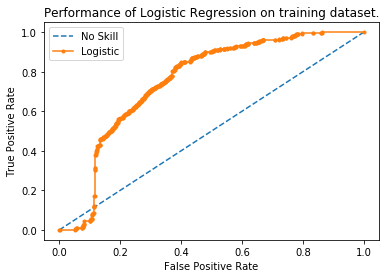

In [26]:
# Plot logistic regression model on training data without validation data.
model = LogisticRegression(solver='lbfgs' , max_iter=1000)

# Here I am giving the entire training data for the model to train. However, I am using a subset of training data for testing.
x_tr_tr , x_ts_tr , y_tr_tr, y_ts_tr = train_test_split(x_tr,y_tr,test_size = 0.20 , random_state = 42)
plot_performance(model , x_tr , x_ts_tr , y_tr, y_ts_tr, 'Performance of Logistic Regression on training dataset.' )

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.761
Accuracy: 0.5704545454545454
Precision: 0.25679347826086957
Recall: 0.9043062200956937
F1 Score:  0.39999999999999997


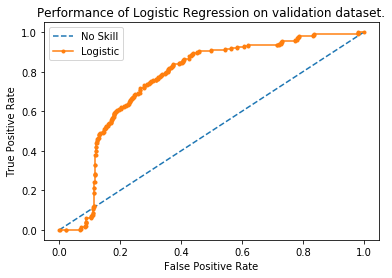

In [27]:
# Plot the performance using validation data set.
plot_performance(model , x_tr , x_ts , y_tr, y_ts,'Performance of Logistic Regression on validation dataset.' )

### As you can see the performance of our model has increased greatly with over-sampling. From the results we can interpret that the model has correctly identified most of the mush compounds(Recall = 90%). However, it has inccorrectly identified 75%  non-mush compounds as mush compounds(Precision = 25%). Thus we get an accuracy of 57%.

## Random Forest Classification Model

D:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000
Accuracy: 0.9972035794183445
Precision: 1.0
Recall: 0.9943566591422122
F1 Score:  0.9971703452178834


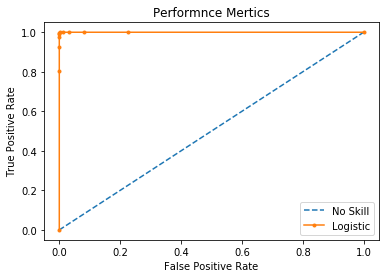

In [28]:
# Create the model.
model = RandomForestClassifier(oob_score=True)

# Plot the performance.
plot_performance(model , x_tr , x_ts_tr , y_tr, y_ts_tr )

### Random Forest has performed very well on the training data. However , there is a chance of overfitting as we get accuracy = 1.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.964
Accuracy: 0.9393939393939394
Precision: 0.8274111675126904
Recall: 0.7799043062200957
F1 Score:  0.8029556650246304


D:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Programming\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


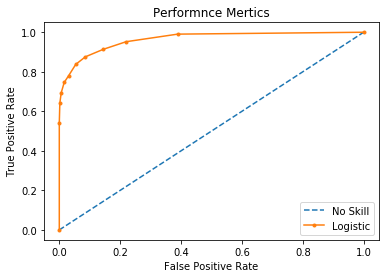

In [31]:
plot_performance(model , x_tr , x_ts , y_tr, y_ts )

### We get an accuracy of 94% on our validation data-set. This is not too bad, considering there was no hypertuning involved.

## Gradient boosting with hyper-tuning.

In [118]:
tr_df_X, test_df_X , tr_df_Y , test_df_Y = x_tr , x_ts , y_tr , y_ts

In [98]:
# Import the library
from sklearn.ensemble import GradientBoostingClassifier

# Hypertune the parameters.
n = [10,20,30,50,100,150,200]
n_e = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=i , random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' N-Estmators ' , i)
    print(' Accuracy ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        n_e = i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if  ((temp_pre)<f1_score(test_df_Y , y_pred)):
            n_e = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)
    
print(' The value n_estimators is ' , n_e , ' with Accuracy ', temp_acc , ' with f1 ' , temp_pre)    

 N-Estmators  10
 Accuracy  0.8151515151515152
 f1 Score  0.5658362989323844
 N-Estmators  20
 Accuracy  0.8333333333333334
 f1 Score  0.6057347670250895
 N-Estmators  30
 Accuracy  0.843939393939394
 f1 Score  0.6268115942028986
 N-Estmators  50
 Accuracy  0.8522727272727273
 f1 Score  0.6460980036297642
 N-Estmators  100
 Accuracy  0.8727272727272727
 f1 Score  0.6818181818181818
 N-Estmators  150
 Accuracy  0.9
 f1 Score  0.7338709677419354
 N-Estmators  200
 Accuracy  0.9075757575757576
 f1 Score  0.7479338842975206
 The value n_estimators is  200  with Accuracy  0.9075757575757576  with f1  0.7479338842975206


In [99]:
n = [50,75,80,90,100,150,200,250,500]
mS = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=n_e , min_samples_split=i, random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' min-samples-split ' , i)
    print(' Accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        mS = i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if ((temp_pre)<f1_score(test_df_Y , y_pred)):
            mS = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)
    
print(' min-samples-split is ' , mS , ' with Accuracy ', temp_acc , ' with f1 ' , temp_pre)   

 min-samples-split  50
 Accuracy Score  0.9007575757575758
 f1 Score  0.7331975560081466
 min-samples-split  75
 Accuracy Score  0.9083333333333333
 f1 Score  0.7535641547861507
 min-samples-split  80
 Accuracy Score  0.9053030303030303
 f1 Score  0.7464503042596349
 min-samples-split  90
 Accuracy Score  0.9075757575757576
 f1 Score  0.7530364372469636
 min-samples-split  100
 Accuracy Score  0.9045454545454545
 f1 Score  0.7407407407407409
 min-samples-split  150
 Accuracy Score  0.9030303030303031
 f1 Score  0.7419354838709677
 min-samples-split  200
 Accuracy Score  0.9037878787878788
 f1 Score  0.7434343434343434
 min-samples-split  250
 Accuracy Score  0.9030303030303031
 f1 Score  0.7387755102040816
 min-samples-split  500
 Accuracy Score  0.9
 f1 Score  0.7370517928286853
 min-samples-split is  75  with Accuracy  0.9083333333333333  with f1  0.7535641547861507


In [100]:
n = [10,20,25,30,35,38,32,40,50,75,80,90,100]
mL = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=n_e , min_samples_split=mS, min_samples_leaf=i, random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' min_samples_leaf ' , i)
    print(' Accuracy ' , accuracy_score(test_df_Y , y_pred))
    print(' Prescision Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        mL = i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if  ((temp_pre)<f1_score(test_df_Y , y_pred)):
            mL = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)
    
print(' min_samples_leaf is ' , mL , ' with accuracy ', temp_acc , ' with f1 ' , temp_pre)

 min_samples_leaf  10
 Accuracy  0.9075757575757576
 Prescision Score  0.7468879668049794
 min_samples_leaf  20
 Accuracy  0.9083333333333333
 Prescision Score  0.7525562372188139
 min_samples_leaf  25
 Accuracy  0.9075757575757576
 Prescision Score  0.7479338842975206
 min_samples_leaf  30
 Accuracy  0.9
 Prescision Score  0.7359999999999999
 min_samples_leaf  35
 Accuracy  0.9090909090909091
 Prescision Score  0.7530864197530863
 min_samples_leaf  38
 Accuracy  0.9068181818181819
 Prescision Score  0.7505070993914806
 min_samples_leaf  32
 Accuracy  0.8962121212121212
 Prescision Score  0.7265469061876249
 min_samples_leaf  40
 Accuracy  0.9030303030303031
 Prescision Score  0.7398373983739838
 min_samples_leaf  50
 Accuracy  0.8954545454545455
 Prescision Score  0.724
 min_samples_leaf  75
 Accuracy  0.9007575757575758
 Prescision Score  0.7342799188640974
 min_samples_leaf  80
 Accuracy  0.8931818181818182
 Prescision Score  0.7196819085487076
 min_samples_leaf  90
 Accuracy  0.903

In [101]:
n = [10,20,25,30,35,38,32,40,50,75,80]
mD = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=n_e , min_samples_split=mS, min_samples_leaf=mL,max_depth=i,  random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' max_depth ' , i)
    print(' Accuracy ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        mD = i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if  ((temp_pre)<f1_score(test_df_Y , y_pred)):
            mD = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)
    
print(' max_depth is ' , mD , ' with Accuracy ', temp_acc , ' with f1 ' , temp_pre)  

 max_depth  10
 Accuracy  0.9409090909090909
 f1  0.8142857142857144
 max_depth  20
 Accuracy  0.946969696969697
 f1  0.8309178743961352
 max_depth  25
 Accuracy  0.9446969696969697
 f1  0.8257756563245824
 max_depth  30
 Accuracy  0.9431818181818182
 f1  0.8166259168704156
 max_depth  35
 Accuracy  0.9446969696969697
 f1  0.8215158924205378
 max_depth  38
 Accuracy  0.943939393939394
 f1  0.8203883495145632
 max_depth  32
 Accuracy  0.9446969696969697
 f1  0.8232445520581113
 max_depth  40
 Accuracy  0.9477272727272728
 f1  0.8337349397590362
 max_depth  50
 Accuracy  0.9431818181818182
 f1  0.8166259168704156
 max_depth  75
 Accuracy  0.9431818181818182
 f1  0.8166259168704156
 max_depth  80
 Accuracy  0.9431818181818182
 f1  0.8166259168704156
 max_depth is  40  with Accuracy  0.9477272727272728  with f1  0.8337349397590362


### Max-Depth is an important parameter as we can see an increase in performance by varying max-depth.

In [102]:
n = [2,3,4,5,6,8,9,10,20,25,30,35,38,32,40,50,75,80]
mxL = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=n_e , min_samples_split=mS, min_samples_leaf=mL,max_depth=i,max_leaf_nodes=i, random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' max_leaf_nodes ' , i)
    print(' Accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        mxL = i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if ((temp_pre)<f1_score(test_df_Y , y_pred)):
            mxL = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)
    
print(' max_leaf_nodes is ' , mD , ' with Accuracy ', temp_acc , ' with f1 ' , temp_pre)

 max_leaf_nodes  2
 Accuracy Score  0.821969696969697
 f1 Score  0.5927209705372618
 max_leaf_nodes  3
 Accuracy Score  0.843939393939394
 f1 Score  0.6360424028268551
 max_leaf_nodes  4
 Accuracy Score  0.8772727272727273
 f1 Score  0.6896551724137931
 max_leaf_nodes  5
 Accuracy Score  0.8871212121212121
 f1 Score  0.7072691552062869
 max_leaf_nodes  6
 Accuracy Score  0.9083333333333333
 f1 Score  0.7505154639175258
 max_leaf_nodes  8
 Accuracy Score  0.9106060606060606
 f1 Score  0.7521008403361344
 max_leaf_nodes  9
 Accuracy Score  0.9068181818181819
 f1 Score  0.7399577167019027
 max_leaf_nodes  10
 Accuracy Score  0.9143939393939394
 f1 Score  0.7590618336886994
 max_leaf_nodes  20
 Accuracy Score  0.9287878787878788
 f1 Score  0.7853881278538812
 max_leaf_nodes  25
 Accuracy Score  0.9363636363636364
 f1 Score  0.8055555555555555
 max_leaf_nodes  30
 Accuracy Score  0.9401515151515152
 f1 Score  0.8141176470588234
 max_leaf_nodes  35
 Accuracy Score  0.9424242424242424
 f1 Sco

In [103]:
n = [0.1 * x for x in range(1,21)]
lR = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=n_e , min_samples_split=mS, min_samples_leaf=mL,max_depth=mD,max_leaf_nodes=mxL, learning_rate=i, random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' learning_rate ' , i)
    print(' accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        lR = i
        temp_accuracy = accuracy_score(test_df_Y , y_pred)
        temp_f1 = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if ((temp_f1)<f1_score(test_df_Y , y_pred)):
            lR = i
            temp_accuracy = accuracy_score(test_df_Y , y_pred)
            temp_f1 = f1_score(test_df_Y , y_pred)
    
print(' learning_rates is ' , lR , ' with accuracy ', temp_accuracy , ' with f1 ' , temp_f1)  

 learning_rate  0.1
 accuracy Score  0.9462121212121212
 f1 Score  0.8321513002364065
 learning_rate  0.2
 accuracy Score  0.9446969696969697
 f1 Score  0.826603325415677
 learning_rate  0.30000000000000004
 accuracy Score  0.9462121212121212
 f1 Score  0.83054892601432
 learning_rate  0.4
 accuracy Score  0.9515151515151515
 f1 Score  0.8461538461538461
 learning_rate  0.5
 accuracy Score  0.943939393939394
 f1 Score  0.8229665071770335
 learning_rate  0.6000000000000001
 accuracy Score  0.95
 f1 Score  0.8428571428571427
 learning_rate  0.7000000000000001
 accuracy Score  0.9462121212121212
 f1 Score  0.8337236533957846
 learning_rate  0.8
 accuracy Score  0.9446969696969697
 f1 Score  0.8306264501160094
 learning_rate  0.9
 accuracy Score  0.9492424242424242
 f1 Score  0.840855106888361
 learning_rate  1.0
 accuracy Score  0.9393939393939394
 f1 Score  0.8148148148148148
 learning_rate  1.1
 accuracy Score  0.9446969696969697
 f1 Score  0.8298368298368298
 learning_rate  1.200000000

### Varying the learning rate also helped us in getting better prformance from our model.

In [104]:
n = [2,3,4,5,6,7,8]
mF = 0
counter = 0
for i in n:
    gr = GradientBoostingClassifier(n_estimators=n_e , min_samples_split=mS, min_samples_leaf=mL,max_depth=mD,max_leaf_nodes=mxL, learning_rate=lR,max_features=i, random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' max_-features ' , i)
    print(' accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        mF = i
        temp_accuracy = accuracy_score(test_df_Y , y_pred)
        temp_f1 = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if ((temp_f1)<f1_score(test_df_Y , y_pred)):
            mF = i
            temp_accuracy = accuracy_score(test_df_Y , y_pred)
            temp_f1 = f1_score(test_df_Y , y_pred)
    
print(' max-features ' , mF , ' with accuracy ', temp_accuracy , ' with f1 ' , temp_f1)  

 max_-features  2
 accuracy Score  0.9462121212121212
 f1 Score  0.831353919239905
 max_-features  3
 accuracy Score  0.9477272727272728
 f1 Score  0.8353221957040574
 max_-features  4
 accuracy Score  0.9409090909090909
 f1 Score  0.8142857142857144
 max_-features  5
 accuracy Score  0.9424242424242424
 f1 Score  0.8173076923076922
 max_-features  6
 accuracy Score  0.9431818181818182
 f1 Score  0.8210023866348448
 max_-features  7
 accuracy Score  0.9446969696969697
 f1 Score  0.8257756563245824
 max_-features  8
 accuracy Score  0.9515151515151515
 f1 Score  0.8461538461538461
 max-features  8  with accuracy  0.9515151515151515  with f1  0.8461538461538461


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.970
Accuracy: 0.9515151515151515
Precision: 0.8502415458937198
Recall: 0.8421052631578947
F1 Score:  0.8461538461538461


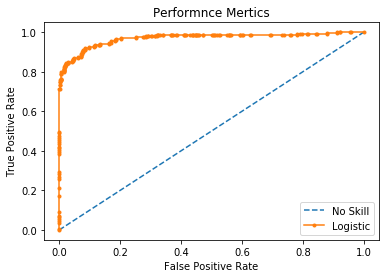

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=40,
                           max_features=8, max_leaf_nodes=50,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=35, min_samples_split=75,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [105]:
# plot the performance.
gr.set_params(max_features = mF)
plot_performance(gr, tr_df_X, test_df_X , tr_df_Y , test_df_Y)
gr.get_params

### Gradient Boost Classifier has given the best results.

## Ada-Boost with Hypertuning

In [83]:
# Import the library
from sklearn.ensemble import AdaBoostClassifier

# Hypertune the parameters.
n = [10,20,30,50,100,150,200,500,1000]
n_e = 0
counter = 0
for i in n:
    gr = AdaBoostClassifier(n_estimators=i , random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' N-Estmators ' , i)
    print(' Accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        n_e = i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if  ((temp_pre)<f1_score(test_df_Y , y_pred)):
            n_e = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)
    
print(' The value n_estimators is ' , n_e , ' with Accuracy ', temp_acc , ' with f1 ' , temp_pre)  

 N-Estmators  10
 Accuracy Score  0.8151515151515152
 f1 Score  0.5906040268456375
 N-Estmators  20
 Accuracy Score  0.8075757575757576
 f1 Score  0.5766666666666667
 N-Estmators  30
 Accuracy Score  0.828030303030303
 f1 Score  0.6010544815465729
 N-Estmators  50
 Accuracy Score  0.8318181818181818
 f1 Score  0.6091549295774648
 N-Estmators  100
 Accuracy Score  0.8378787878787879
 f1 Score  0.6205673758865248
 N-Estmators  150
 Accuracy Score  0.853030303030303
 f1 Score  0.6472727272727273
 N-Estmators  200
 Accuracy Score  0.8568181818181818
 f1 Score  0.6493506493506493
 N-Estmators  500
 Accuracy Score  0.8560606060606061
 f1 Score  0.6428571428571428
 N-Estmators  1000
 Accuracy Score  0.8674242424242424
 f1 Score  0.6615087040618955
 The value n_estimators is  1000  with Accuracy  0.8674242424242424  with f1  0.6615087040618955


In [84]:
n = [0.1 * x for x in range(1,51)]
lR = 0
counter = 0
for i in n:
    gr = AdaBoostClassifier(n_estimators=n_e , learning_rate=i , random_state=42)
    gr.fit(tr_df_X , tr_df_Y)
    y_pred = gr.predict(test_df_X)
    print(' learning-rate ' , i)
    print(' accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        lR = i
        temp_accuracy = accuracy_score(test_df_Y , y_pred)
        temp_f1 = f1_score(test_df_Y , y_pred)
        counter += 1
    else:
        if ((temp_f1)<f1_score(test_df_Y , y_pred)):
            lR = i
            temp_accuracy = accuracy_score(test_df_Y , y_pred)
            temp_f1 = f1_score(test_df_Y , y_pred)
    
print(' learning-rate ' , lR , ' with accuracy ', temp_accuracy , ' with f1 ' , temp_f1) 

 learning-rate  0.1
 accuracy Score  0.843939393939394
 f1 Score  0.6321428571428571
 learning-rate  0.2
 accuracy Score  0.8537878787878788
 f1 Score  0.6535008976660681
 learning-rate  0.30000000000000004
 accuracy Score  0.8553030303030303
 f1 Score  0.6508226691042047
 learning-rate  0.4
 accuracy Score  0.8537878787878788
 f1 Score  0.6458715596330276
 learning-rate  0.5
 accuracy Score  0.8537878787878788
 f1 Score  0.6458715596330276
 learning-rate  0.6000000000000001
 accuracy Score  0.8606060606060606
 f1 Score  0.6567164179104478
 learning-rate  0.7000000000000001
 accuracy Score  0.8636363636363636
 f1 Score  0.660377358490566
 learning-rate  0.8
 accuracy Score  0.8674242424242424
 f1 Score  0.6628131021194604
 learning-rate  0.9
 accuracy Score  0.8666666666666667
 f1 Score  0.6615384615384615
 learning-rate  1.0
 accuracy Score  0.8674242424242424
 f1 Score  0.6615087040618955
 learning-rate  1.1
 accuracy Score  0.8666666666666667
 f1 Score  0.6575875486381323
 learning-

In [91]:
gr.set_params(learning_rate=lR , n_estimators = n_e)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.5,
                   n_estimators=1000, random_state=42)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.936
Accuracy: 0.8772727272727273
Precision: 0.5780730897009967
Recall: 0.8325358851674641
F1 Score:  0.6823529411764705


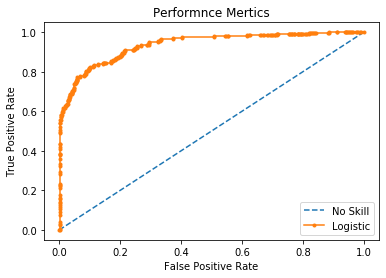

<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.5,
                   n_estimators=1000, random_state=42)>

In [92]:
# Applying various algorithms to get a better score.
plot_performance(gr, tr_df_X, test_df_X , tr_df_Y , test_df_Y)
gr.get_params

### ADA Boost classifier is giving low-precision but high recall. Hence, it's classifying a lot of NON-MUSK compounds as MUSK-Compounds.

## Support Vector Classifier with hypertuning.

In [114]:
from sklearn.svm import LinearSVC

# Hypertune parameters.
n = [2,8,10,12,15,20,25,28,30,35,50,55,60,70,75,80,100,150,125,175,200,250,300]
counter = 0
c = 0
for i in n:
    lSVR = LinearSVC(C=i )
    lSVR.fit(tr_df_X, tr_df_Y)
    y_pred = lSVR.predict(test_df_X)
    print(' C ' , i)
    print(' accuracy Score ' , accuracy_score(test_df_Y , y_pred))
    print(' f1 Score ' , f1_score(test_df_Y , y_pred))
    if counter == 0:
        counter+=1
        c=i
        temp_acc = accuracy_score(test_df_Y , y_pred)
        temp_pre = f1_score(test_df_Y , y_pred)
    else:
        if  ((temp_pre)<f1_score(test_df_Y , y_pred)):
            c = i
            temp_acc = accuracy_score(test_df_Y , y_pred)
            temp_pre = f1_score(test_df_Y , y_pred)   
 
    
print(' Penalty(C) ' , c , ' with accuracy ', temp_acc , ' with f1 ' , temp_pre) 

D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  2
 accuracy Score  0.6590909090909091
 f1 Score  0.08906882591093117


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  8
 accuracy Score  0.7265151515151516
 f1 Score  0.057441253263707574


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  10
 accuracy Score  0.740909090909091
 f1 Score  0.19339622641509435


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  12
 accuracy Score  0.6553030303030303
 f1 Score  0.17122040072859745


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  15
 accuracy Score  0.47954545454545455
 f1 Score  0.3561387066541705


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  20
 accuracy Score  0.4015151515151515
 f1 Score  0.3293718166383702


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  25
 accuracy Score  0.43636363636363634
 f1 Score  0.33333333333333337


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  28
 accuracy Score  0.3568181818181818
 f1 Score  0.3125506072874493


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  30
 accuracy Score  0.693939393939394
 f1 Score  0.05164319248826291


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  35
 accuracy Score  0.5492424242424242
 f1 Score  0.3821391484942887


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  50
 accuracy Score  0.4712121212121212
 f1 Score  0.35489833641404805


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  55
 accuracy Score  0.38712121212121214
 f1 Score  0.3184498736310025


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  60
 accuracy Score  0.4727272727272727
 f1 Score  0.35435992578849723


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  70
 accuracy Score  0.6181818181818182
 f1 Score  0.10320284697508897


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  75
 accuracy Score  0.5568181818181818
 f1 Score  0.18181818181818182


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  80
 accuracy Score  0.6833333333333333
 f1 Score  0.05


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  100
 accuracy Score  0.7227272727272728
 f1 Score  0.0418848167539267


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  150
 accuracy Score  0.5015151515151515
 f1 Score  0.36608863198458574


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  125
 accuracy Score  0.693939393939394
 f1 Score  0.019417475728155338


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  175
 accuracy Score  0.6174242424242424
 f1 Score  0.09009009009009009


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  200
 accuracy Score  0.7219696969696969
 f1 Score  0.03674540682414699


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 C  250
 accuracy Score  0.4022727272727273
 f1 Score  0.3262169086251067
 C  300
 accuracy Score  0.6575757575757576
 f1 Score  0.11372549019607844
 Penalty(C)  35  with accuracy  0.5492424242424242  with f1  0.3821391484942887


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [115]:
# Applying various algorithms to get a better score.
lSVR.set_params(C = c)
lSVR.get_params

<bound method BaseEstimator.get_params of LinearSVC(C=35, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)>

In [119]:
# Printing the performance of SVC.
lSVR.fit(tr_df_X , tr_df_Y)
y_pred = lSVR.predict(test_df_X)
print(' Accuracy score of Support Vector Machine classifier is: ' , accuracy_score(test_df_Y , y_pred))
print(' Recall score of Support Vector Machine classifier is: ' , recall_score(test_df_Y , y_pred))
print(' Precision score of Support Vector Machine classifier is: ' , precision_score(test_df_Y , y_pred))
print(' F1 score of Support Vector Machine classifier is: ' , f1_score(test_df_Y , y_pred))

 Accuracy score of Support Vector Machine classifier is:  0.7318181818181818
 Recall score of Support Vector Machine classifier is:  0.0430622009569378
 Precision score of Support Vector Machine classifier is:  0.05521472392638037
 F1 score of Support Vector Machine classifier is:  0.048387096774193554


D:\Programming\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Support Vector CLassifier is not-showing good performance for our dataset.